Shapes:
  train_labels: (5410, 2)
  beneficiary : (63780, 25)
  inpatient   : (24797, 30)
  outpatient  : (35166, 27)

--- Granularity & keys ---
train_labels columns: ['Provider', 'PotentialFraud']
beneficiary  columns: ['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov'] ...
inpatient    columns: ['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'AdmissionDt'] ...
outpatient   columns: ['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1'] ...

Unique keys:
  Providers (labels): 5410
  BeneID (beneficiaries): 63780
  ClaimID (inpatient): 24797
  ClaimID (outpatient): 35166

Providers that appear in claims vs labels:
  Providers in inpatient claims: 1974
  Providers in outpatient claims: 3

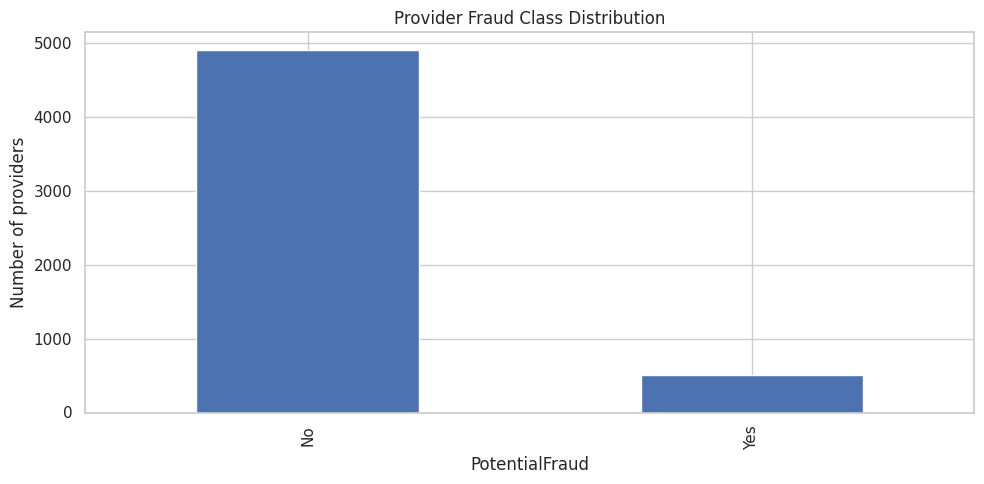


Share of inpatient claims from fraudulent providers: 0.5760203258590095
Share of outpatient claims from fraudulent providers: 0.36148552579195814


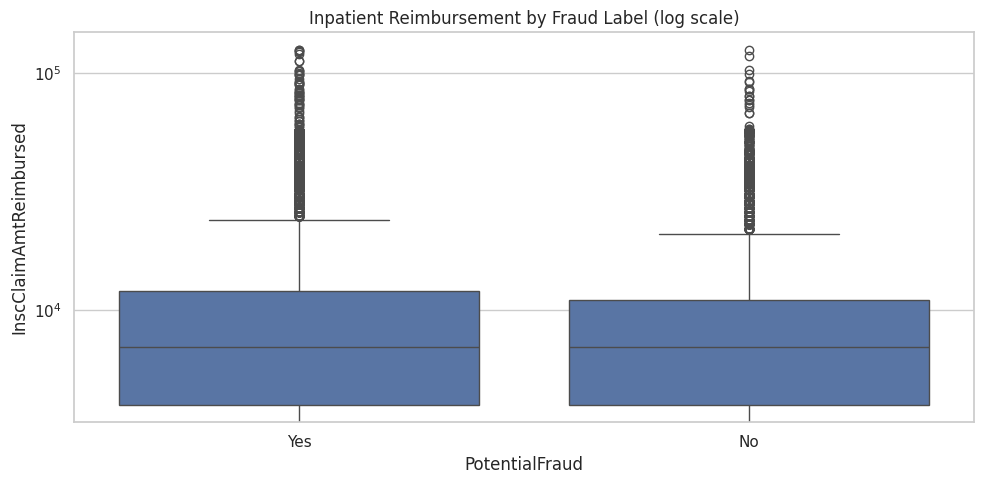

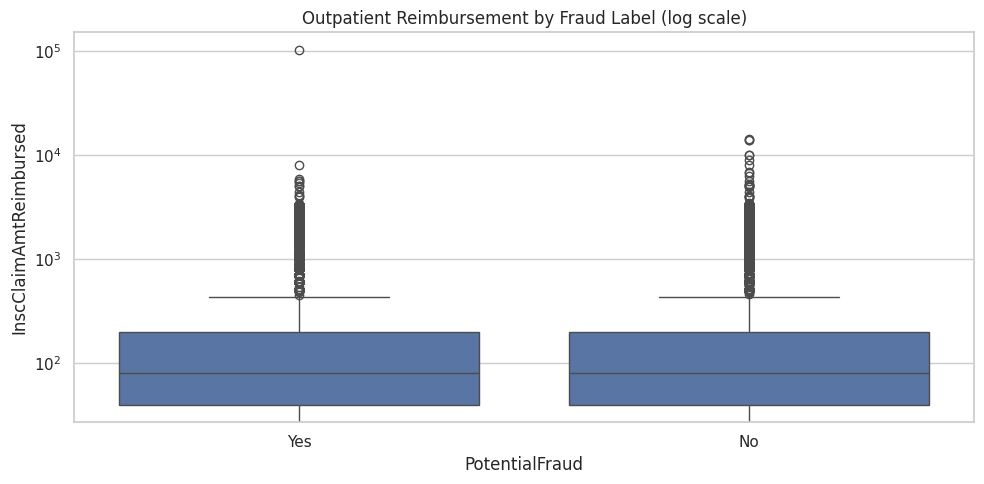

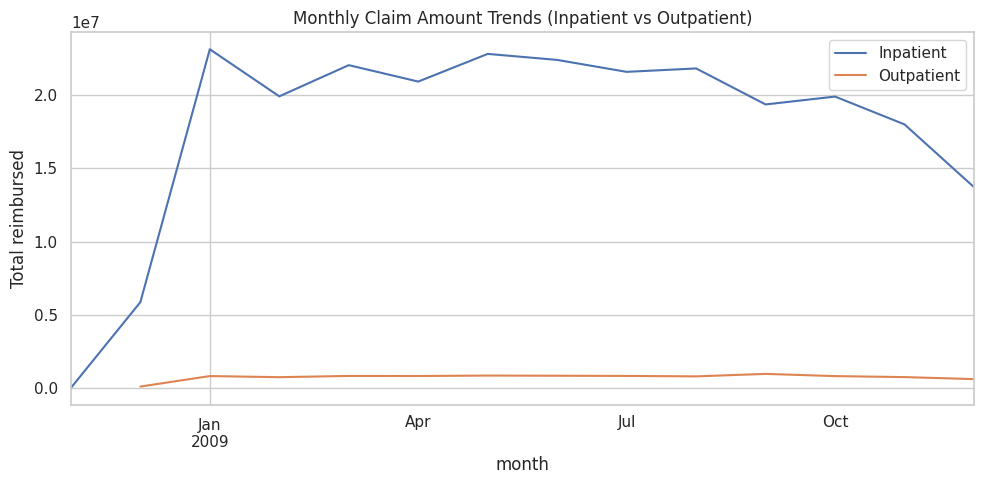


Provider-level aggregated head:
         PotentialFraud  inp_claim_count  inp_total_reimb  inp_mean_reimb  \
Provider                                                                    
PRV51001             No              3.0          51000.0    17000.000000   
PRV51003            Yes             36.0         257000.0     7138.888889   
PRV51004             No              NaN              NaN             NaN   
PRV51005            Yes              NaN              NaN             NaN   
PRV51007             No              3.0          19000.0     6333.333333   

          inp_unique_bene  outp_claim_count  outp_total_reimb  \
Provider                                                        
PRV51001              3.0               1.0              20.0   
PRV51003             29.0               8.0            7380.0   
PRV51004              NaN               5.0            2380.0   
PRV51005              NaN              76.0           15920.0   
PRV51007              3.0            

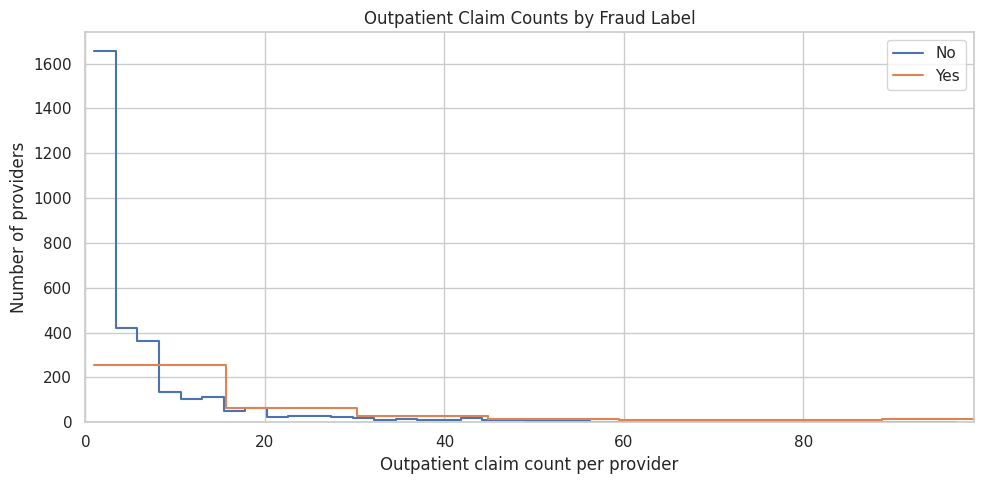

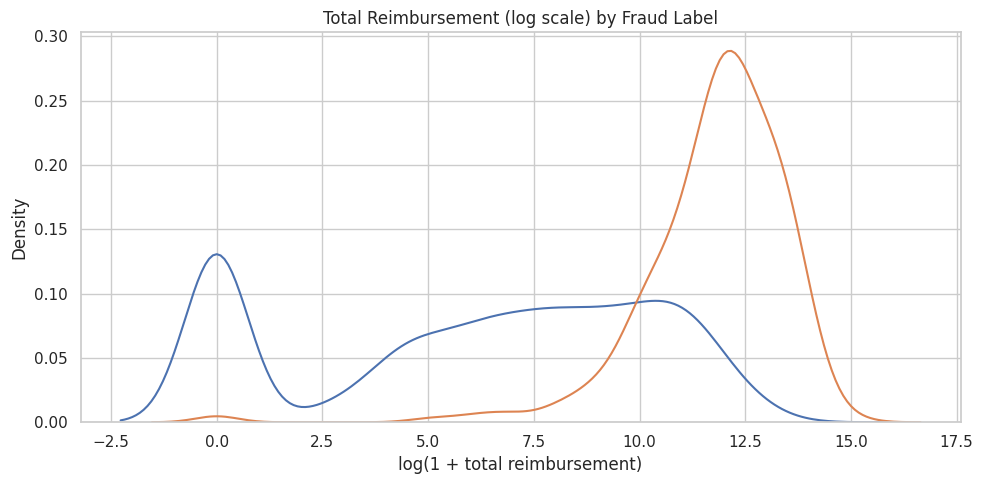

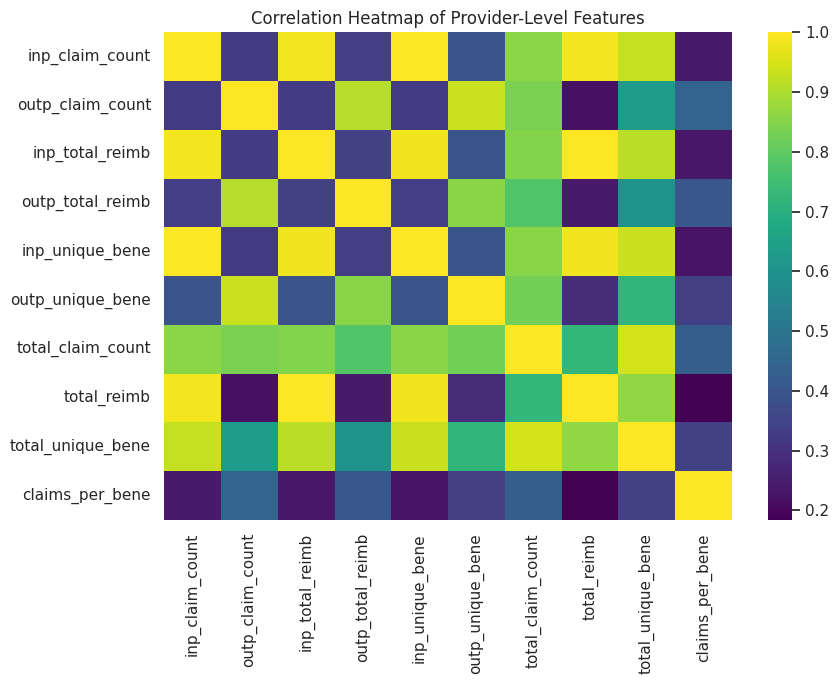


State-level provider fraud rates (based on presence in claims):
PotentialFraud        No       Yes
State                             
9.0             0.529412  0.470588
30.0            0.568182  0.431818
41.0            0.642857  0.357143
47.0            0.653846  0.346154
29.0            0.666667  0.333333
53.0            0.666667  0.333333
8.0             0.692308  0.307692
13.0            0.709677  0.290323
31.0            0.720670  0.279330
6.0             0.739726  0.260274


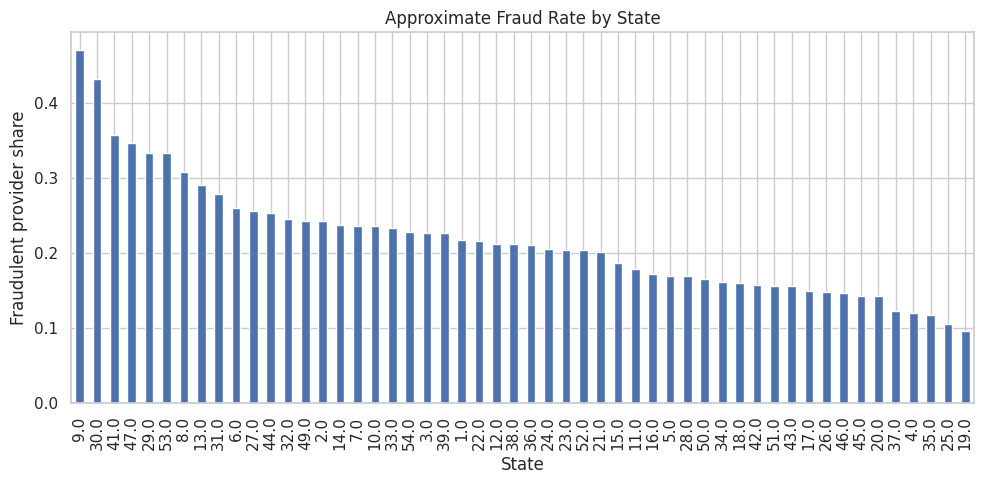

In [1]:
# ================================
# 1. Imports & Data Loading
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 5)
sns.set(style="whitegrid")

# ---- file names (change if yours are different) ----
TRAIN_LABELS_FILE = "Train-1542865627584.csv"               # Provider, PotentialFraud
TRAIN_BENE_FILE   = "Train_Beneficiarydata-1542865627584.csv"
TRAIN_INP_FILE    = "Train_Inpatientdata-1542865627584.csv"
TRAIN_OUTP_FILE   = "Train_Outpatientdata-1542865627584.csv"

# ---- load data ----
train_labels = pd.read_csv(TRAIN_LABELS_FILE)
train_bene   = pd.read_csv(TRAIN_BENE_FILE)
train_inp    = pd.read_csv(TRAIN_INP_FILE)
train_outp   = pd.read_csv(TRAIN_OUTP_FILE)

print("Shapes:")
print("  train_labels:", train_labels.shape)
print("  beneficiary :", train_bene.shape)
print("  inpatient   :", train_inp.shape)
print("  outpatient  :", train_outp.shape)

# ================================
# 2. Relationships & Granularity
# ================================
print("\n--- Granularity & keys ---")
print("train_labels columns:", train_labels.columns.tolist())
print("beneficiary  columns:", train_bene.columns.tolist()[:10], "...")
print("inpatient    columns:", train_inp.columns.tolist()[:10], "...")
print("outpatient   columns:", train_outp.columns.tolist()[:10], "...")

print("\nUnique keys:")
print("  Providers (labels):", train_labels["Provider"].nunique())
print("  BeneID (beneficiaries):", train_bene["BeneID"].nunique())
print("  ClaimID (inpatient):", train_inp["ClaimID"].nunique())
print("  ClaimID (outpatient):", train_outp["ClaimID"].nunique())

# check for one-row-per-entity assumptions
assert train_labels["Provider"].is_unique, "Provider not unique in labels!"
assert train_bene["BeneID"].is_unique, "BeneID not unique in beneficiary!"

# ----------------------------
# Keys / relationships:
#   BeneID   -> beneficiary table
#   BeneID   -> inpatient/outpatient claims
#   Provider -> labels
#   Provider -> inpatient/outpatient claims
# ----------------------------

# Examine overlaps
print("\nProviders that appear in claims vs labels:")
print("  Providers in inpatient claims:", train_inp["Provider"].nunique())
print("  Providers in outpatient claims:", train_outp["Provider"].nunique())

# ================================
# 3. Data Quality & Missing Values
# ================================
def missing_report(df, name, top_n=15):
    """Print top_n columns with highest missing ratio."""
    miss = df.isna().mean().sort_values(ascending=False)
    print(f"\nMissing values in {name} (top {top_n}):")
    print((miss * 100).head(top_n).round(2).astype(str) + "%")

missing_report(train_bene, "beneficiary")
missing_report(train_inp, "inpatient")
missing_report(train_outp, "outpatient")

# simple consistency checks
print("\nCheck negative reimbursements:")
print("  Inpatient negative reimb:", (train_inp["InscClaimAmtReimbursed"] < 0).sum())
print("  Outpatient negative reimb:", (train_outp["InscClaimAmtReimbursed"] < 0).sum())

# ================================
# 4. EDA – Fraud label distribution
# ================================
fraud_counts = train_labels["PotentialFraud"].value_counts().sort_index()
fraud_rate = (train_labels["PotentialFraud"] == "Yes").mean()
print("\nFraud rate (providers):", fraud_rate)

plt.figure()
fraud_counts.plot(kind="bar")
plt.title("Provider Fraud Class Distribution")
plt.xlabel("PotentialFraud")
plt.ylabel("Number of providers")
plt.tight_layout()
plt.show()

# ================================
# 5. Map labels to claims
# ================================
fraud_map = train_labels.set_index("Provider")["PotentialFraud"]

inp = train_inp.copy()
outp = train_outp.copy()
inp["PotentialFraud"] = inp["Provider"].map(fraud_map)
outp["PotentialFraud"] = outp["Provider"].map(fraud_map)

# keep only claims for providers that exist in label table
inp = inp.dropna(subset=["PotentialFraud"])
outp = outp.dropna(subset=["PotentialFraud"])

print("\nShare of inpatient claims from fraudulent providers:",
      (inp["PotentialFraud"] == "Yes").mean())
print("Share of outpatient claims from fraudulent providers:",
      (outp["PotentialFraud"] == "Yes").mean())

# ================================
# 6. Exploratory Analysis on Claims
# ================================

# ---- Claim amount distributions ----
plt.figure()
sns.boxplot(data=inp, x="PotentialFraud", y="InscClaimAmtReimbursed")
plt.yscale("log")
plt.title("Inpatient Reimbursement by Fraud Label (log scale)")
plt.tight_layout()
plt.show()

plt.figure()
sns.boxplot(data=outp, x="PotentialFraud", y="InscClaimAmtReimbursed")
plt.yscale("log")
plt.title("Outpatient Reimbursement by Fraud Label (log scale)")
plt.tight_layout()
plt.show()

# ---- Claim amount trends over time ----
# parse dates
for col in ["ClaimStartDt", "ClaimEndDt"]:
    inp[col]  = pd.to_datetime(inp[col])
    outp[col] = pd.to_datetime(outp[col])

inp_month = (
    inp.assign(month=inp["ClaimStartDt"].dt.to_period("M").dt.to_timestamp())
       .groupby("month")["InscClaimAmtReimbursed"].sum()
)
outp_month = (
    outp.assign(month=outp["ClaimStartDt"].dt.to_period("M").dt.to_timestamp())
        .groupby("month")["InscClaimAmtReimbursed"].sum()
)

plt.figure()
inp_month.plot(label="Inpatient")
outp_month.plot(label="Outpatient")
plt.legend()
plt.ylabel("Total reimbursed")
plt.title("Monthly Claim Amount Trends (Inpatient vs Outpatient)")
plt.tight_layout()
plt.show()

# ================================
# 7. Provider-level Aggregation Strategy
# ================================
# Aggregate inpatient claims by provider
agg_inp = inp.groupby("Provider").agg(
    inp_claim_count=("ClaimID", "nunique"),
    inp_total_reimb=("InscClaimAmtReimbursed", "sum"),
    inp_mean_reimb=("InscClaimAmtReimbursed", "mean"),
    inp_unique_bene=("BeneID", "nunique")
)

# Aggregate outpatient claims by provider
agg_outp = outp.groupby("Provider").agg(
    outp_claim_count=("ClaimID", "nunique"),
    outp_total_reimb=("InscClaimAmtReimbursed", "sum"),
    outp_mean_reimb=("InscClaimAmtReimbursed", "mean"),
    outp_unique_bene=("BeneID", "nunique")
)

# Merge with provider labels
provider_agg = (
    train_labels.set_index("Provider")
    .join(agg_inp)
    .join(agg_outp)
)

# Create combined features
provider_agg["total_claim_count"] = (
    provider_agg["inp_claim_count"].fillna(0) +
    provider_agg["outp_claim_count"].fillna(0)
)
provider_agg["total_reimb"] = (
    provider_agg["inp_total_reimb"].fillna(0) +
    provider_agg["outp_total_reimb"].fillna(0)
)
provider_agg["total_unique_bene"] = (
    provider_agg["inp_unique_bene"].fillna(0) +
    provider_agg["outp_unique_bene"].fillna(0)
)
provider_agg["claims_per_bene"] = (
    provider_agg["total_claim_count"] /
    (provider_agg["total_unique_bene"] + 1)
)
provider_agg["inp_to_outp_ratio"] = (
    provider_agg["inp_claim_count"].fillna(0) /
    (provider_agg["outp_claim_count"].fillna(0) + 1)
)

print("\nProvider-level aggregated head:")
print(provider_agg.head())

# ================================
# 8. Compare Fraudulent vs Legitimate Providers
# ================================
cols_to_compare = [
    "inp_claim_count", "outp_claim_count",
    "inp_total_reimb", "outp_total_reimb",
    "total_claim_count", "total_reimb",
    "total_unique_bene", "claims_per_bene"
]

summary_by_fraud = provider_agg.groupby("PotentialFraud")[cols_to_compare].median()
print("\nMedian provider metrics by fraud label:")
print(summary_by_fraud)

# Example histograms of provider metrics
plt.figure()
for label in ["No", "Yes"]:
    subset = provider_agg[provider_agg["PotentialFraud"] == label]["outp_claim_count"].dropna()
    sns.histplot(subset, bins=40, kde=False, stat="count", label=label, element="step", fill=False)
plt.legend()
plt.xlim(0, provider_agg["outp_claim_count"].quantile(0.99))  # trim extreme tail
plt.xlabel("Outpatient claim count per provider")
plt.ylabel("Number of providers")
plt.title("Outpatient Claim Counts by Fraud Label")
plt.tight_layout()
plt.show()

plt.figure()
for label in ["No", "Yes"]:
    subset = provider_agg[provider_agg["PotentialFraud"] == label]["total_reimb"].dropna()
    sns.kdeplot(np.log1p(subset), label=label)
plt.xlabel("log(1 + total reimbursement)")
plt.title("Total Reimbursement (log scale) by Fraud Label")
plt.tight_layout()
plt.show()

# ================================
# 9. Correlation Heatmap (Provider-level)
# ================================
num_cols = [
    "inp_claim_count", "outp_claim_count",
    "inp_total_reimb", "outp_total_reimb",
    "inp_unique_bene", "outp_unique_bene",
    "total_claim_count", "total_reimb",
    "total_unique_bene", "claims_per_bene"
]

corr = provider_agg[num_cols].corr()

plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=False, cmap="viridis")
plt.title("Correlation Heatmap of Provider-Level Features")
plt.tight_layout()
plt.show()

# ================================
# 10. Geographic Patterns (by State)
# ================================
# Join beneficiary state into claims → provider
bene_small = train_bene[["BeneID", "State", "County"]]

# attach state to inpatient / outpatient claims
inp_geo = inp[["BeneID", "Provider"]].merge(bene_small, on="BeneID", how="left")
outp_geo = outp[["BeneID", "Provider"]].merge(bene_small, on="BeneID", how="left")

# provider-state mapping (a provider can appear in multiple states,
# here we count all provider-state pairs)
inp_geo["PotentialFraud"] = inp_geo["Provider"].map(fraud_map)
outp_geo["PotentialFraud"] = outp_geo["Provider"].map(fraud_map)

# state-level fraud rate based on providers that operate in that state
state_provider = pd.concat([
    inp_geo[["State", "Provider", "PotentialFraud"]],
    outp_geo[["State", "Provider", "PotentialFraud"]]
]).dropna(subset=["State"]).drop_duplicates()

state_stats = (
    state_provider
    .groupby("State")["PotentialFraud"]
    .value_counts(normalize=True)
    .rename("rate")
    .reset_index()
    .pivot(index="State", columns="PotentialFraud", values="rate")
    .fillna(0)
)
state_stats = state_stats.sort_values(by="Yes", ascending=False)

print("\nState-level provider fraud rates (based on presence in claims):")
print(state_stats.head(10))

plt.figure(figsize=(10, 5))
state_stats["Yes"].plot(kind="bar")
plt.ylabel("Fraudulent provider share")
plt.title("Approximate Fraud Rate by State")
plt.tight_layout()
plt.show()


In [2]:
# Save provider-level features for modeling notebook
OUTPUT_FILE = "provider_features.csv"
provider_agg.to_csv(OUTPUT_FILE, index=True)
print(f"Saved provider-level dataset to {OUTPUT_FILE}")


Saved provider-level dataset to provider_features.csv
